# Informed Search: Admissibility

This notebook will investigate the admissibility of priority list heuristics. 

In order for informed methods like A* search to be optimal, it must be admissible: $h(n) \leq h^{*}(n)$. In other words, it must be an optimistic estimate of the path cost. 

One way to design a heuristic satisfying this constraint is to design a heuristic based on a priority list. Priority list methods commit generators in order of marginal cost. Often the operating constraints are ignored initially, and then some heuristic methods are used to fix the resulting schedule. 

In `ts4uc` we have designed a simple heuristic that commits generators in priority list order, ignoring constraints, then calculates the economic dispatch by simply using the cost per MWh when operating at full capacity. This is very fast to compute and mainly serves to reflect the fact that nodes that are closer to the end of the day will have lower 'cost-to-go' (the cost to the end of the day) then earlier nodes. Importantly, this heuristic does not distinguish between heuristics at the same generation. 

In [44]:
from rl4uc.environment import make_env

from ts4uc.tree_search import informed_search
from ts4uc.tree_search.scenarios import get_net_demand_scenarios
from ts4uc.tree_search.algos import *
from ts4uc.tree_search import node
from ts4uc import helpers

import numpy as np 
import pandas as pd 
import json
import matplotlib.pyplot as plt
import seaborn as sns

### User Inputs

In [114]:
ENV_PARAMS_FN = '../data/day_ahead/5gen/30min/env_params.json'
TEST_DATA_BASE_FN = '../data/day_ahead/5gen/30min/profile_{}.csv'
HORIZON = 2
BRANCHING_THRESHOLD = 0.05
SEED = 1 
NUM_SCENARIOS = 100
TEST_SAMPLE_SEED = 999
NUM_SAMPLES = 100
NUM_PERIODS=48

We will redefine the `solve_day_ahead()` function in order to keep track of the heuristic cost and return this at the end of the search. 

We will also redefine our function for testing schedules to keep track of the period-level operating costs.

In [115]:
def solve_day_ahead(env, 
                    horizon, 
                    net_demand_scenarios,
                    tree_search_func=uniform_cost_search, 
                    **params):
    """
    Solve a day rooted at env. 
    
    Return the schedule and the number of branches at the root for each time period. 
    """
    env.reset()
    final_schedule = np.zeros((env.episode_length, env.num_gen))

    root = node.Node(env=env,
            parent=None,
            action=None,
            step_cost=0,
            path_cost=0)
    
    heuristic_costs = []

    for t in range(env.episode_length):
                
        s = time.time()
        terminal_timestep = min(env.episode_timestep + horizon, env.episode_length-1)
        
        # RTA* heuristic estimate
        h = env.episode_length - env.episode_timestep - 1
#         h = 1
        c = informed_search.heuristic(root, h, params.get('heuristic_method'))
        heuristic_costs.append(c)
        print("Heuristic cost: {}, lookahead: {}".format(c, h))
                
        path, cost = tree_search_func(root, 
                                      terminal_timestep, 
                                      net_demand_scenarios,
                                      **params)
        a_best = path[0]

        print(f"Period {env.episode_timestep+1}", np.array(a_best, dtype=int), round(cost, 2), round(time.time()-s, 2))
        final_schedule[t, :] = a_best
        env.step(a_best, deterministic=True)
        
        root = root.children[a_best.tobytes()]
        root.parent, root.path_cost = None, 0

        gc.collect()
            
    return final_schedule, heuristic_costs

def test_schedule(env, schedule, seed=999, num_samples=1000, deterministic=False):
    costs = np.zeros((num_samples, env.episode_length))
    np.random.seed(seed)
    for i in range(num_samples):
        env.reset()
        total_reward = 0 
        for action in schedule:
            action = np.where(np.array(action)>0, 1, 0)
            obs,reward,done = env.step(action, deterministic)
            costs[i, env.episode_timestep] = -reward
    return costs


In [116]:
def calc_heuristic_preds(test_data_fn, heuristic_method):
    np.random.seed(SEED)

    # Load parameters
    env_params = json.load(open(ENV_PARAMS_FN))

    # Load profile 
    profile_df = pd.read_csv(test_data_fn)
    profile_df = profile_df[:NUM_PERIODS]

    params = {'horizon': HORIZON,
              'branching_threshold': BRANCHING_THRESHOLD,
              'heuristic_method': heuristic_method}

    # Init env
    env = make_env(mode='test', profiles_df=profile_df, **env_params)

    # Load policy
    policy = None

    # Generate scenarios for demand and wind errors
    scenarios = get_net_demand_scenarios(profile_df, env, NUM_SCENARIOS)

    schedule_result, heuristic_costs = solve_day_ahead(env=env, 
                                                       net_demand_scenarios=scenarios, 
                                                       tree_search_func=rta_star,
                                                       policy=policy,
                                                       **params)

    TEST_SAMPLE_SEED=999
    test_costs = test_schedule(env, schedule_result, TEST_SAMPLE_SEED, NUM_SAMPLES)

    pred = np.array(heuristic_costs[:])
    print("Heuristic Predictions: {}".format(pred))
    step_costs = np.mean(test_costs, axis=0)
    print("Actual step costs: {}".format(step_costs))
    actual = np.sum(step_costs) - np.cumsum(step_costs)[:-1]
    actual = np.insert(actual, 0, np.sum(step_costs))
    print("Actual cumulative costs-to-go: {}".format(actual))
    
    return pd.DataFrame({'pred': pred,
                         'actual': actual})

In [117]:
step_costs = np.arange(1,5) 
actual = np.sum(step_costs) - np.cumsum(step_costs)[:-1]
print(actual)
actual = np.insert(actual, 0, 10)
actual

[9 7 4]


array([10,  9,  7,  4])

Heuristic cost: 193890.08146548108, lookahead: 48
Period 0 [1 0 0 0 0] 8191.87 3.75
Heuristic cost: 190921.11420434923, lookahead: 47
Period 1 [1 0 0 0 0] 7833.41 3.63
Heuristic cost: 188253.59800427334, lookahead: 46
Period 2 [1 0 0 0 0] 7960.02 3.45
Heuristic cost: 185714.98527932022, lookahead: 45
Period 3 [1 0 0 0 0] 8230.86 3.28
Heuristic cost: 182906.08536131206, lookahead: 44
Period 4 [1 0 0 0 0] 8291.33 3.48
Heuristic cost: 180051.81655322056, lookahead: 43
Period 5 [1 0 0 0 0] 8512.9 3.52
Heuristic cost: 177197.8543191589, lookahead: 42
Period 6 [1 0 0 0 0] 8717.48 3.03
Heuristic cost: 174108.47205975704, lookahead: 41
Period 7 [1 0 0 0 0] 8674.76 3.05
Heuristic cost: 171011.08047453046, lookahead: 40
Period 8 [1 0 0 0 0] 8543.39 2.81
Heuristic cost: 167952.6470520509, lookahead: 39
Period 9 [1 0 0 0 0] 8493.21 2.88
Heuristic cost: 164997.39147561806, lookahead: 38
Period 10 [1 0 0 0 0] 8488.06 2.78
Heuristic cost: 162003.00962650077, lookahead: 37
Period 11 [1 0 0 0 0] 8652.5

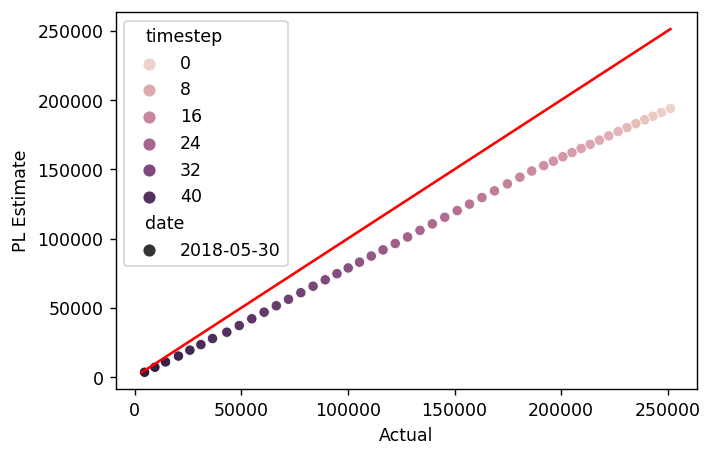

In [118]:
rerun = True
if rerun: 
    df_pred_ls = []
#     for date in ['2016-01-12', '2019-05-22', '2017-04-07', '2018-05-30']:
    for date in ['2018-05-30']:
        test_data_fn = TEST_DATA_BASE_FN.format(date)
        df_pred = calc_heuristic_preds(test_data_fn, 'priority_list')
        df_pred['timestep'] = df_pred.index.copy()
        df_pred['date'] = date
        df_pred_ls.append(df_pred)

    df_pred = pd.concat(df_pred_ls).sort_values(['date', 'timestep'])

    xmin = np.min(df_pred.pred)
    xmax = np.max(df_pred.actual)
    xmin_to_xmax = np.linspace(xmin, xmax)

    fig, ax = plt.subplots(dpi=125)
    ax.plot(xmin_to_xmax, xmin_to_xmax, c='r')
    sns.scatterplot(data=df_pred, x='actual', y='pred', hue='timestep', style='date', legend='brief')
    # ax.scatter(df_pred.actual, df_pred.pred, c=df_pred.timestep)
    ax.set_xlabel('Actual')
    ax.set_ylabel('PL Estimate')
    plt.show()

### A more advanced PL heuristic

In order to improve performance, we will develop a PL heuristic that considers generator constraints. 

In [49]:
def advanced_priority_list(state, horizon):
    """
    Priority list cost estimation for environment for subsequent periods.
    
    In this version, generator constraints must be obeyed
    """
    time_interval = state.dispatch_freq_mins/60

    # Sort to priority list order 
    gen_info_sorted = state.gen_info.sort_values('heat_rates')

    # Net demand forecast
    demand = state.episode_forecast[state.episode_timestep+1:state.episode_timestep+horizon+1]
    wind = state.episode_wind_forecast[state.episode_timestep+1:state.episode_timestep+horizon+1]
    net_demand = demand - wind
         
    uc_schedule = np.zeros([state.num_gen, demand.size])
    free_generators = np.zeros([state.num_gen, demand.size])
    # Fix constrained gens
    for g in range(state.num_gen):
        if state.status[g] < 0:
            n = max(gen_info_sorted.t_min_down.values[g] + state.status[g], 0)
            uc_schedule[g,:n] = 0
        else:
            n = max(gen_info_sorted.t_min_up.values[g] - state.status[g], 0)
            uc_schedule[g,:n] = 1
        free_generators[g,n:] = 1
            
    committed_cap = np.dot(uc_schedule.T, gen_info_sorted.max_output.values)
    residual_load = net_demand - committed_cap

    for t in range(demand.size):
        res = residual_load[t]
        free_gens = np.where(free_generators[:,t] == 1)[0]
        for g in free_gens:
            if res <= 0:
                break
            # Commit the next generator
            uc_schedule[g,t] = 1
            res -= gen_info_sorted.max_output.values[g]

    # Estimate start costs (assume all starts are hot)
    extended_schedule = np.hstack((np.where(state.status > 0, 1, 0).reshape(-1,1),
                              uc_schedule))
    starts = np.sum(np.diff(extended_schedule) == 1, axis=1)
    start_cost = np.dot(gen_info_sorted.hot_cost.values, starts)

    # Estimate fuel costs using average heat rate of online generators, weighted by capacity
    uc_schedule = uc_schedule.T
    weighted_avg_hr = np.zeros(uc_schedule.shape[0])
    
    for t in range(uc_schedule.shape[0]):
        online_gens = np.where(uc_schedule[t])[0]
        weighted_avg_hr[t] = (np.dot(gen_info_sorted.max_cost_per_mwh.values[online_gens], 
                                  gen_info_sorted.min_output.values[online_gens])/
                              np.sum(gen_info_sorted.min_output.values[online_gens]))
        
    fuel_cost = np.dot(weighted_avg_hr, demand) * time_interval
    
    return fuel_cost + start_cost

In [50]:
env = make_env(num_gen=5)
obs = env.reset()
advanced_priority_list(env, 12)

62376.20022196365